In [134]:
%run ./_setup.ipynb

In [2]:
# compare area of subbasins


In [3]:
# function for nonlinear least squares fitting
def fixed_line(t, slope):
    return slope*t

# 3. Calculation of Inflow

To calculate the freshwater inflow to Galveston Bay, we use a control volume of the Bay and apply conservation of volume:

$\begin{align}
\partial V/\partial t &= Q_{fw} + Q_{ch} ~~~~~~~~(1) \\
\Rightarrow Q_{fw}(t) &= \partial V/\partial t - Q_{ch}(t)
\end{align}$

where $V(t)$ is the volume of Galveston Bay, $Q_{fw}(t)$ is the freshwater input to Galveston Bay, and $Q_{ch}(t)$ is the flux in Galveston Bay channel ($Q_{ch}$ is positive into the bay and negative on ebb tide out of the bay.

## 3.1 Bay Volume

Assuming that any change in x/y area of the bay due to flooding is limited (and therefore the surface area and bathymetry are constant), we have the following:

$\begin{align}
\partial V/\partial t &\approx A_s \partial \eta/\partial t, ~~~~~~~~(2)
\end{align}$

where $A_s$ is the surface area of Galveston Bay and $\eta$ is the sea level height.
We use the sea level at station 8771013 in the middle of the main bay to represent the sea level in both the main and east bays, and at stations 8771486 and 8771450 in the west bay to represent that area.

We have three possible surface area values to account for uncertainty. These values were calculated and saved in `0_process_bathymetry.ipynb`. Volume is calculated in the `calc_harvey` function below so that all parameter combinations can be used. Some definitions are set up here for later use.

Now calculate multiple options for the volume of the Bay, $V(t)$, and change in volume of the Bay, $dV/dt$. A rolling mean of 3 hours has been applied to $dV/dt$.

In [4]:
# Sea surface stations used
eta_main = '8771013'  # main bay and East bay together
eta_west = '8771486'  # West bay


# V = (Am * (Hm + df['%s: Water Level [m, MHW]' % eta_main])) + (Aw * (Hw + df['%s: Water Level [m, MHW]' % eta_west]))
# dVdt = (V.diff()/dt).rolling(center=True, window=4*3).mean()


## 3.2 Channel Flux

### 3.2.1 ADCP data

We have data from an upward-facing ADCP from NOAA PORTS station `g06010` that spans much of the water column. We choose three ways to extrapolate the velocity data to be continuous from seabed from sea surface: piecewise linear, 2nd order polynomial, and 3rd order polynomial. This is done in the "Gather Data" notebook.

In [5]:
# Calculate the standared deviation and mean across along-channel velocity signals to use later
std_uch = df[['smean','smean_2nd','smean_3rd']].std(axis=1)
mean_uch = df[['smean','smean_2nd','smean_3rd']].mean(axis=1)

### 3.2.2 Salinity conservation

Conservation of salinity in Galveston Bay gives:

$
\begin{align}
d (S V)/d t &= S_{in}Q_{fw} + S_{ch} Q_{ch} \\
d (S V)/d t &=  S_{ch} Q_{ch} \\
\Rightarrow Q_{ch} &= \frac{1}{S_{ch}} \frac{d (S V)}{d t}  ~~~~~~~~~~~~~~~~~~ (4)
\end{align}
$

where the input salinity, $S_{in}$, is assumed to be fresh so $S_{in}=0$ and $S_{ch}$ is the channel salinity.

We have data from TWDB station BOLI to represent $S_{ch}$. Rayson et al 2017 finds that the volume-averaged salinity in the bay is reasonably represented by three TWDB stations: $S(t) = \frac{1}{3} TRIN + \frac{1}{3} MIDG + \frac{1}{3} BOLI$; we use this result.

The derivative term is calculated as follows, where the volume is approximated as the surface area times the average depth plus a representative sea surface height:

$
\begin{align}
    \frac{\partial (S V)}{\partial t} &= A_s \frac{\partial [S(H+\eta)]} {\partial t}.~~~~~~~~~~~~~~~~~~ (5)
\end{align}
$

We calculate this term for both of the bays (main and East together, and West Bay separately).

In [6]:
# Calculate volume averaged salinity
Sch = df['BOLI: Salinity']  # rename channel salinity

Solve for $Q_{ch}$ from conservation of salinity, Equation 4. Also solve for $Q_{fw}$, the freshwater flux, from Equation 1 using this $Q_{ch}$. It does not apply during the flooding when $S_{ch}=0$, but it does give results at other times.

The following is to find a range of values for $A_{eq}$ and metrics for when they should be valid.

In [7]:
start = pd.Timestamp('2017-8-1')
stop = pd.Timestamp('2017-10-1')

In [565]:
## finding equivalent area and then final result for different inputs, Section 3.2.3 ##
def calc_harvey(smean, midgweight, Amain, Awest, Hmain, Hwest, Vconstant, date):
    
    ## Calculate things ##
    # salinity
    S = ((1-0.33-midgweight)*df['TRIN: Salinity'] + midgweight*df['MIDG: Salinity'] + 0.33*Sch)  # volume averaged salinity

    if Vconstant:
        V = Amain * Hmain + Awest * Hwest      
        dVdt = 0
    else:  # V variable
        V = (Amain * (Hmain + df['%s: Water Level [m, MHW]' % eta_main])) + (Awest * (Hwest + df['%s: Water Level [m, MHW]' % eta_west]))
        dVdt = (V.diff()/dt).rolling(center=True, window=4*3).mean()[start:stop]
    
    dSVdt = (S*V).diff()/dt
    Qch = (dSVdt/Sch)
#     Qr = Qch + dVdt
    ####
    
    ## Prep for more calculations ##
    enddate = date + pd.Timedelta('%i days' % ndays)

    Ut = df[smean][date:enddate].copy()
    Qt = Qch.loc[date:enddate].copy()
    Scht = Sch[date:enddate].copy()
    St = S[date:enddate].copy()
    
    indf = Ut > 0  # into the bay, flood tide
    inde = Ut < 0  # out of the bay, ebb tide
    ####

    ## flood ##
    Uf = Ut[indf].copy()
    Qf = Qt[indf].copy()
    Stf = St[indf].copy()
    Schtf = Scht[indf].copy()
    ind = (~Uf.isnull()) & (~Qf.isnull())
    Uf = Uf[ind]; Qf = Qf[ind]; Stf = Stf[ind]; Schtf = Schtf[ind]
    ####
    
    ## ebb ##
    Ue = Ut[inde].copy()
    Qe = Qt[inde].copy()
    Ste = St[inde].copy()
    Schte = Scht[inde].copy()
    ind = (~Ue.isnull()) & (~Qe.isnull())
    Ue = Ue[ind]; Qe = Qe[ind]; Schte = Schte[ind]; Ste = Ste[ind]
    ####

    npts = (len(Ue) + len(Uf))/len(Ut)  # ratio pts included

    Qcht = df[smean].copy()
    Uchf = df[smean][df[smean] > 0]; Uche = df[smean][df[smean] < 0]

    # may not work bc missing data
    # straight line
    if not Ue.empty and not Qe.empty and not Uf.empty and not Qf.empty:
        fite = curve_fit(fixed_line, Ue, Qe)
        fitf = curve_fit(fixed_line, Uf, Qf)

        ## Equation 3 after finding equivalent area for this loop ##
        Qcht[df[smean] > 0] = Uchf*fitf[0]
        Qcht[df[smean] < 0] = Uche*fite[0]
        
        area_ebb = fite[0][0]
        area_flood = fitf[0][0]

        # this is now the improved flux calculation which applies during the storm too
        Qchnew = Qcht.copy()[start:stop]

        # Section 3.3: inflow rate calculation
        Qrfin = (-Qchnew + dVdt)

        # Inflow volume calculation
        # save Harvey inflow
        harvey = Qrfin[date_outflow:date_endoutflow].sum()*dt/1000**3

        # save Harvey inflow WITHOUT dVdt term for comparison
        harvey_nodVdt = -Qchnew[date_outflow:date_endoutflow].sum()*dt/1000**3
        
        Qch = Qch[start:stop]
        
    else:
        harvey = np.nan
        Qrfin = np.nan
        harvey_nodVdt = np.nan
        area_ebb = np.nan
        area_flood = np.nan
        dVdt = np.nan
        Qchnew = np.nan
        Qch = np.nan
            
    return npts, harvey, Qrfin, harvey_nodVdt, area_ebb, area_flood, dVdt, Qchnew, Qch


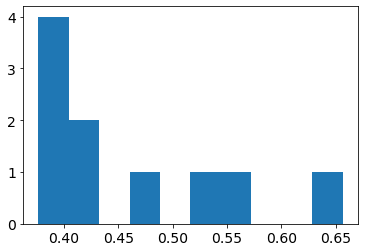

In [566]:
# Things to vary or set otherwise
smeans = ['smean', 'smean_2nd', 'smean_3rd']


# data time periods
ndays = 27  # 28 days total since first day is included
dates_use = dates[::4*24*7*2]



# weights for salinity
# exponential distribution between 0.33 and 0.67 for weight for MIDG — TRIN is remainder with BOLI as 0.33
loc = 0.33; scale = .1
pdf = expon(loc=loc, scale=scale)
midgweights = pdf.rvs(10)
plt.hist(midgweights)
midgweights = np.linspace(1/3-1/6, 1/3+1/6, 10)

# # Gaussian distribution of surface areas
# nareas = 10
# # main bay
# loc = bathy.attrs['A_main_center']; scale = bathy.attrs['A_main_std']
# pdf = norm(loc=loc, scale=scale)
# Amains = pdf.rvs(nareas)
# # west bay
# loc = bathy.attrs['A_west_center']; scale = bathy.attrs['A_west_std']
# pdf = norm(loc=loc, scale=scale)
# Awests = pdf.rvs(nareas)

# From Gaussian distribution in 0_process_bathy.ipynb, chose ratio of 
# 2 to 2 to 1 to 1 for the 4 bathymetries, respectively
arr = bathy['Amain'].values*1000**2
Amains = [arr[0], arr[0],
          arr[1], 
          arr[2]]
#           arr[3]]  # m^2
arr = bathy['Awest'].values
Awests = [arr[0], arr[0],
          arr[1], 
          arr[2]]
#           arr[3]]  # m^2
arr = bathy['Hmain'].values
Hmains = [arr[0], arr[0],
          arr[1], 
          arr[2]]
#           arr[3]]  # m^2
arr = bathy['Hwest'].values
Hwests = [arr[0], arr[0],
          arr[1], 
          arr[2]]
#           arr[3]]  # m^2


# difference in cumulative sums after ndays days, in km^3
# nrows = len(smeans)*len(dates_use)*len(midgweights)

# Have volume calculated either without (assume eta=0) or with SSH data
Vconstants = [True, False]


In [568]:
%%time
ncalcs = len(smeans)*len(dates_use)*midgweights.size*len(Amains)*len(Vconstants)

cols = ['npts','harvey inflow [km^3]','harvey inflow - no dVdt [km^3]',
        'effective area (ebb)','effective area (flood)', 'midgweight', 
                    'Amain', 'Awest', 'Hmain', 'Hwest', 'Vconstant']
index = pd.date_range(start, stop, freq='15T')

i = 0
tsarr = np.zeros((index.size,ncalcs))
dVdtarr = np.zeros((index.size,ncalcs))
Qcharr = np.zeros((index.size,ncalcs))
Qchsaltarr = np.zeros((index.size,ncalcs))
smeanlist = []
dateslist = []
harvarr = np.zeros((ncalcs,len(cols)))  # number of calculations by columns to save

for smean in smeans:
    for date in dates_use:
        for midgweight in midgweights:
            for Amain, Awest, Hmain, Hwest in zip(Amains, Awests, Hmains, Hwests):
                for Vconstant in Vconstants:

                    a, b, c, d, e, f, g, h, k = calc_harvey(smean, midgweight, Amain, Awest, Hmain, Hwest,
                                                             Vconstant, date)

                    # save time series into arrays during loop. Too slow to put directly into dataframe.
                    tsarr[:,i] = c
                    dVdtarr[:,i] = g
                    Qcharr[:,i] = h
                    Qchsaltarr[:,i] = k

                    harvarr[i,:] = np.array([a,b,d,e,f, midgweight, Amain, Awest, Hmain, Hwest, Vconstant])

                    smeanlist.append(smean)
                    dateslist.append(date)

                    i += 1
    
# reconstitute
ts = pd.DataFrame(tsarr, index=index)
dVdt = pd.DataFrame(dVdtarr, index=index)
Qch = pd.DataFrame(Qcharr, index=index)
Qchsalt = pd.DataFrame(Qchsaltarr, index=index)
harv = pd.DataFrame(harvarr, index=np.arange(ncalcs), columns=cols)
harv['smean'] = smeanlist
harv['date'] = dateslist


CPU times: user 16min 13s, sys: 1min 55s, total: 18min 9s
Wall time: 18min 12s


Run through all the combinations of inputs to get a best estimate for inflow and uncertainty.

In [575]:
harv

,npts,harvey inflow [km^3],harvey inflow - no dVdt [km^3],effective area (ebb),effective area (flood),midgweight,Amain,Awest,Hmain,Hwest,Vconstant,smean,date
0,0.000000,NaN,NaN,NaN,NaN,0.166667,1.164313e+09,394.393508,2.521176,1.397450,1.0,smean,2014-01-01
1,0.000000,NaN,NaN,NaN,NaN,0.166667,1.164313e+09,394.393508,2.521176,1.397450,0.0,smean,2014-01-01
2,0.000000,NaN,NaN,NaN,NaN,0.166667,1.164313e+09,394.393508,2.521176,1.397450,1.0,smean,2014-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31437,0.998267,15.018102,15.505173,27331.026868,49007.106311,0.500000,1.164313e+09,343.075263,2.521176,1.482733,0.0,smean_3rd,2018-12-26
31438,0.998267,10.294846,10.294846,18041.036253,31720.591439,0.500000,1.257831e+09,421.548826,2.473181,1.327325,1.0,smean_3rd,2018-12-26
31439,0.998267,16.024583,16.550776,29176.166994,52327.817082,0.500000,1.257831e+09,421.548826,2.473181,1.327325,0.0,smean_3rd,2018-12-26


Median of Harvey inflow estimates: 16.7
Mean of Harvey inflow estimates: 17.9
Standard deviation of Harvey inflow estimates: 5.2
Number of valid Harvey inflow estimates: 2160
Number of total Harvey inflow estimates: 15720
Median of Harvey inflow estimates with no dV/dt included: 17.2
% difference in inflow when dVdt excluded: 3.0


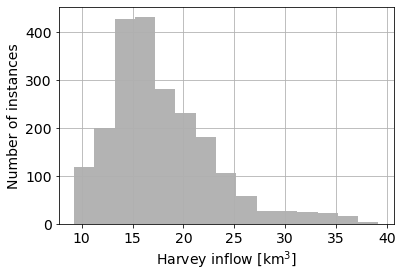

In [622]:
# nptsmin = 0.8

# save full results and make harv only have time-changing volume calculations
harvsave = harv.copy()
harv = harv[harv['Vconstant'] == 0]

inpts = harv['npts'] > nptsmin
iharvey = (harv['date'] > pd.Timestamp('2017-7-25')) & (harv['date'] < pd.Timestamp('2017-9-24'))
ibad2018 = harv['date'] > pd.Timestamp('2018-5-1')
iuse = inpts & ~iharvey & ~ibad2018
key = 'harvey inflow [km^3]'
ax = (harv[key][iuse]).hist(bins=15, color='0.7')
ax.set_xlabel('Harvey inflow [km$^3$]')
ax.set_ylabel('Number of instances')

Vfw = harv[key][iuse].median()
Vfwstd = harv[key][iuse].std()
Vfw_nodVdt = harv['harvey inflow - no dVdt [km^3]'][iuse].median()

print('Median of Harvey inflow estimates: %2.1f' % Vfw)
print('Mean of Harvey inflow estimates: %2.1f' % harv[key][iuse].mean())  # for reference
print('Standard deviation of Harvey inflow estimates: %2.1f' % Vfwstd)
print('Number of valid Harvey inflow estimates: %2i' % len(harv[iuse]))
print('Number of total Harvey inflow estimates: %2i' % len(harv))
print('Median of Harvey inflow estimates with no dV/dt included: %2.1f' % Vfw_nodVdt)
print('%% difference in inflow when dVdt excluded: %2.1f' % ((Vfw_nodVdt-Vfw)/Vfw*100))


# # overlay a few lines
# ylims = ax.get_ylim()
# ax.vlines(Vfw, *ylims, lw=2)
# ax.vlines(Vfw - Vfwstd, *ylims, lw=2)

plt.savefig('../figures/histogram.pdf', bbox_inches='tight')

Median of Harvey inflow estimates: 16.7
Mean of Harvey inflow estimates: 17.9
Standard deviation of Harvey inflow estimates: 5.2
Number of valid Harvey inflow estimates: 2160
Number of total Harvey inflow estimates: 15720
Median of Harvey inflow estimates with no dV/dt included: 17.2
% difference in inflow when dVdt excluded: 3.0


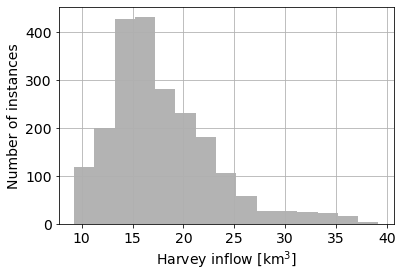

In [443]:
# nptsmin = 0.8

inpts = harv['npts'] > nptsmin
iharvey = (harv['date'] > pd.Timestamp('2017-7-25')) & (harv['date'] < pd.Timestamp('2017-9-24'))
ibad2018 = harv['date'] > pd.Timestamp('2018-5-1')
iuse = inpts & ~iharvey & ~ibad2018
key = 'harvey inflow [km^3]'
ax = (harv[key][iuse]).hist(bins=15, color='0.7')
ax.set_xlabel('Harvey inflow [km$^3$]')
ax.set_ylabel('Number of instances')

Vfw = harv[key][iuse].median()
Vfwstd = harv[key][iuse].std()
Vfw_nodVdt = harv['harvey inflow - no dVdt [km^3]'][iuse].median()

print('Median of Harvey inflow estimates: %2.1f' % Vfw)
print('Mean of Harvey inflow estimates: %2.1f' % harv[key][iuse].mean())  # for reference
print('Standard deviation of Harvey inflow estimates: %2.1f' % Vfwstd)
print('Number of valid Harvey inflow estimates: %2i' % len(harv[iuse]))
print('Number of total Harvey inflow estimates: %2i' % len(harv))
print('Median of Harvey inflow estimates with no dV/dt included: %2.1f' % Vfw_nodVdt)
print('%% difference in inflow when dVdt excluded: %2.1f' % ((Vfw_nodVdt-Vfw)/Vfw*100))


# # overlay a few lines
# ylims = ax.get_ylim()
# ax.vlines(Vfw, *ylims, lw=2)
# ax.vlines(Vfw - Vfwstd, *ylims, lw=2)

plt.savefig('../figures/histogram.pdf', bbox_inches='tight')

Median of Harvey inflow estimates: 17.8
Mean of Harvey inflow estimates: 19.2
Standard deviation of Harvey inflow estimates: 6.1
Number of valid Harvey inflow estimates: 2160
Number of total Harvey inflow estimates: 15720
Median of Harvey inflow estimates with no dV/dt included: 18.3
% difference in inflow when dVdt excluded: 2.9


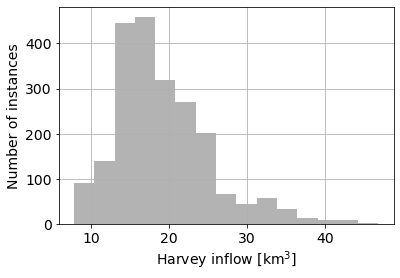

In [431]:
# nptsmin = 0.8

inpts = harv['npts'] > nptsmin
iharvey = (harv['date'] > pd.Timestamp('2017-7-25')) & (harv['date'] < pd.Timestamp('2017-9-24'))
ibad2018 = harv['date'] > pd.Timestamp('2018-5-1')
iuse = inpts & ~iharvey & ~ibad2018
key = 'harvey inflow [km^3]'
ax = (harv[key][iuse]).hist(bins=15, color='0.7')
ax.set_xlabel('Harvey inflow [km$^3$]')
ax.set_ylabel('Number of instances')

Vfw = harv[key][iuse].median()
Vfwstd = harv[key][iuse].std()
Vfw_nodVdt = harv['harvey inflow - no dVdt [km^3]'][iuse].median()

print('Median of Harvey inflow estimates: %2.1f' % Vfw)
print('Mean of Harvey inflow estimates: %2.1f' % harv[key][iuse].mean())  # for reference
print('Standard deviation of Harvey inflow estimates: %2.1f' % Vfwstd)
print('Number of valid Harvey inflow estimates: %2i' % len(harv[iuse]))
print('Number of total Harvey inflow estimates: %2i' % len(harv))
print('Median of Harvey inflow estimates with no dV/dt included: %2.1f' % Vfw_nodVdt)
print('%% difference in inflow when dVdt excluded: %2.1f' % ((Vfw_nodVdt-Vfw)/Vfw*100))


# # overlay a few lines
# ylims = ax.get_ylim()
# ax.vlines(Vfw, *ylims, lw=2)
# ax.vlines(Vfw - Vfwstd, *ylims, lw=2)

plt.savefig('../figures/histogram.pdf', bbox_inches='tight')

Median of Harvey inflow estimates: 17.1
Mean of Harvey inflow estimates: 18.2
Standard deviation of Harvey inflow estimates: 5.3
Number of valid Harvey inflow estimates: 2160
Number of total Harvey inflow estimates: 15720
Median of Harvey inflow estimates with no dV/dt included: 17.6
% difference in inflow when dVdt excluded: 3.0


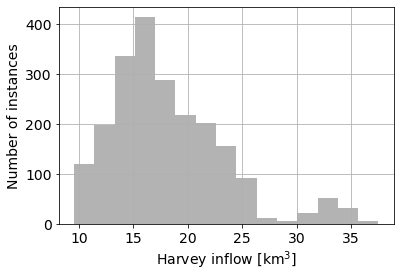

In [299]:
# nptsmin = 0.8

inpts = harv['npts'] > nptsmin
iharvey = (harv['date'] > pd.Timestamp('2017-7-25')) & (harv['date'] < pd.Timestamp('2017-9-24'))
ibad2018 = harv['date'] > pd.Timestamp('2018-5-1')
iuse = inpts & ~iharvey & ~ibad2018
key = 'harvey inflow [km^3]'
ax = (harv[key][iuse]).hist(bins=15, color='0.7')
ax.set_xlabel('Harvey inflow [km$^3$]')
ax.set_ylabel('Number of instances')

Vfw = harv[key][iuse].median()
Vfwstd = harv[key][iuse].std()
Vfw_nodVdt = harv['harvey inflow - no dVdt [km^3]'][iuse].median()

print('Median of Harvey inflow estimates: %2.1f' % Vfw)
print('Mean of Harvey inflow estimates: %2.1f' % harv[key][iuse].mean())  # for reference
print('Standard deviation of Harvey inflow estimates: %2.1f' % Vfwstd)
print('Number of valid Harvey inflow estimates: %2i' % len(harv[iuse]))
print('Number of total Harvey inflow estimates: %2i' % len(harv))
print('Median of Harvey inflow estimates with no dV/dt included: %2.1f' % Vfw_nodVdt)
print('%% difference in inflow when dVdt excluded: %2.1f' % ((Vfw_nodVdt-Vfw)/Vfw*100))


# # overlay a few lines
# ylims = ax.get_ylim()
# ax.vlines(Vfw, *ylims, lw=2)
# ax.vlines(Vfw - Vfwstd, *ylims, lw=2)

plt.savefig('../figures/histogram.pdf', bbox_inches='tight')

Examine these results for when the weights for salinity stations for calculating volume-average salinity were set to the Rayson estimate of 1/3, 1/3, 1/3.

0.3148148148148148
16.70794550270066
4.994183693327787


(array([22., 51., 50., 30., 30., 17.,  4.,  3.,  4.,  5.]),
 array([10.082413  , 12.53677429, 14.99113558, 17.44549687, 19.89985816,
        22.35421945, 24.80858074, 27.26294202, 29.71730331, 32.1716646 ,
        34.62602589]),
 <a list of 10 Patch objects>)

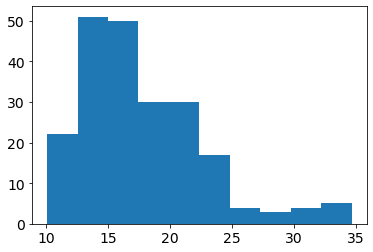

In [477]:
im = np.where(midgweights <= 0.33)[0][-1]
print(midgweights[im])
inds = harv[iuse]['midgweight'] == midgweights[im]
Vfw_midg = harv[iuse][inds][key].median()
print(Vfw_midg)
print(harv[iuse][inds][key].std())
plt.hist(harv[iuse][inds][key])



In [479]:
4.16/15.4, 5/16.7, 6/18.2

(0.2701298701298701, 0.29940119760479045, 0.32967032967032966)

0.16666666666666666
15.417772945945256
4.161489448176124
0.5
18.22909237332425
6.092883073568671


0.16852749747506576

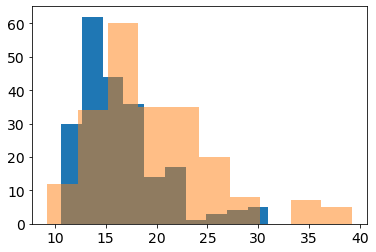

In [459]:
print(harv[iuse]['midgweight'].min())
inds = harv[iuse]['midgweight'] == harv[iuse]['midgweight'].min()
Vfw_Smin = harv[iuse][inds][key].median()
print(Vfw_Smin)
print(harv[iuse][inds][key].std())
plt.hist(harv[iuse][inds][key])

print(harv[iuse]['midgweight'].max())
inds = harv[iuse]['midgweight'] == harv[iuse]['midgweight'].max()
Vfw_Smax = harv[iuse][inds][key].median()
print(Vfw_Smax)
print(harv[iuse][inds][key].std())
plt.hist(harv[iuse][inds][key], alpha=0.5)

(Vfw_Smax - Vfw_Smin)/Vfw

for given surface area, date, smean, etc, how much uncertainty does S introduce?

In [624]:
harv2 = harv[iuse]


## uncertainty due to salinity station weights
ncalcs = len(smeans)*len(harv2[iuse]['date'].unique())*len(Amains)
std_midgweights = np.zeros((ncalcs,1))
i=0
                           
for smean in smeans:
    for date in harv2[iuse]['date'].unique():  # just use dates that result in good numbers
        for Amain, Awest in zip(Amains, Awests):

                inds = (harv2['Amain'] == Amain) & (harv2['Awest'] == Awest) & (harv2['smean'] == smean) \
                        & (harv2['date'] == date)
                std_midgweights[i] = harv2[inds][key].std()
                i += 1

                
## uncertainty due to ADCP profile extrapolation method
ncalcs = midgweights.size*len(harv2[iuse]['date'].unique())*len(Amains)
std_smeans = np.zeros((ncalcs,1))
i=0
                           
for midgweight in midgweights:
    for date in harv2[iuse]['date'].unique():  # just use dates that result in good numbers
        for Amain, Awest in zip(Amains, Awests):

                inds = (harv2['Amain'] == Amain) & (harv2['Awest'] == Awest) & (harv2['midgweight'] == midgweight) \
                        & (harv2['date'] == date)
                std_smeans[i] = harv2[inds][key].std()
                i += 1

                
## uncertainty due to dates used
ncalcs = midgweights.size*len(smeans)*len(Amains)
std_dates = np.zeros((ncalcs,1))
i=0
                           
for midgweight in midgweights:
    for smean in smeans:  # just use dates that result in good numbers
        for Amain, Awest in zip(Amains, Awests):

                inds = (harv2['Amain'] == Amain) & (harv2['Awest'] == Awest) & (harv2['midgweight'] == midgweight) \
                        & (harv2['smean'] == smean)
                std_dates[i] = harv2[inds][key].std()
                i += 1


## uncertainty due to surface area
ncalcs = midgweights.size*len(harv2[iuse]['date'].unique())*len(smeans)
std_areas = np.zeros((ncalcs,1))
i=0
                           
for midgweight in midgweights:
    for date in harv2[iuse]['date'].unique():  # just use dates that result in good numbers
        for smean in smeans:

                inds = (harv2['smean'] == smean) & (harv2['midgweight'] == midgweight) & (harv2['date'] == date)
                std_areas[i] = harv2[inds][key].std()
                i += 1
        
## uncertainty due to volume being constant or not
# not using constant volume in calculations except for here
inpts = harvsave['npts'] > nptsmin
iharvey = (harvsave['date'] > pd.Timestamp('2017-7-25')) & (harv['date'] < pd.Timestamp('2017-9-24'))
ibad2018 = harvsave['date'] > pd.Timestamp('2018-5-1')
iuse3 = inpts & ~iharvey & ~ibad2018
harv3 = harvsave[iuse3]
ncalcs = midgweights.size*len(smeans)*len(Amains)*len(harv3[iuse2]['date'].unique())
std_Vconstant = np.zeros((ncalcs,1))
i=0
                           
for midgweight in midgweights:
    for date in harv3[iuse2]['date'].unique():  # just use dates that result in good numbers
        for smean in smeans:  # just use dates that result in good numbers
            for Amain, Awest in zip(Amains, Awests):

                inds = (harv3['Amain'] == Amain) & (harv3['Awest'] == Awest) & (harv3['midgweight'] == midgweight) \
                         & (harv3['date'] == date) & (harv3['smean'] == smean)
                std_Vconstant[i] = harv3[inds][key].std()
                i += 1


/Users/kthyng/miniconda3/envs/cart/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Users/kthyng/miniconda3/envs/cart/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/Users/kthyng/miniconda3/envs/cart/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/kthyng/miniconda3/envs/cart/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/kthyng/miniconda3/envs/cart/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/kthyng/miniconda3/envs/cart/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Boolean Series

5.129530495295169 0.5649340112860654 0.9597570684419447 0.6611461447573279 3.2358689520019186


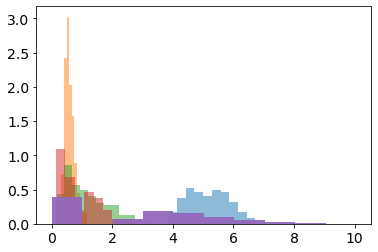

In [627]:
plt.hist(std_dates, alpha=0.5, density=True)
plt.hist(std_areas, alpha=0.5, density=True)
plt.hist(std_midgweights, alpha=0.5, density=True)
plt.hist(std_smeans, alpha=0.5, density=True)
plt.hist(std_Vconstant, alpha=0.95, density=True)
print(np.median(std_dates), np.median(std_areas), np.median(std_midgweights), 
                    np.median(std_smeans), np.nanmedian(std_Vconstant))
                                                                                                                

Read in TWDB inflow estimates

In [12]:
# convert = 0.0142764  # 1 acre-foot per day = 0.0142764 m^3/s

# fname = '%s%s' % (baset, 'updated_daily_gauged_modelled_1Aug2017-30Sep2017.txt')
# twdb = pd.read_table(fname, parse_dates=True, index_col=0)*convert
# twdb['inflow'] = twdb.sum(axis=1)

In [13]:
# read in TWDB prediction of ungauged/modeled inflow by TWDB subbasin
Files = glob('%s/galv_ws_modelled_runoff/*' % (baset))
twdb = pd.DataFrame()
convert = 0.0142764  # 1 acre-foot per day = 0.0142764 m^3/s
for File in Files:
    dft = pd.read_table(File, delim_whitespace=True, parse_dates=[[0,1,2]], index_col=0)*convert
    dft.columns = [dft.columns[0][:5] + ' [m^3/s]'] # rename
    twdb = pd.concat([twdb, dft], axis=1)

In [14]:
# read in TWDB prediction of gauged inflow by TWDB subbasin TWDB prediction of
Files = glob('%s/gauged_flow/*' % (baset))
for File in Files:
    dft = pd.read_table(File, delim_whitespace=True, parse_dates=[[0,1,2]], index_col=0)*convert
    dft.columns = [dft.columns[0].split('_')[0] + ' [m^3/s]'] # rename
    if not dft.columns[0] in twdb.columns:
        twdb = pd.concat([twdb, dft], axis=1)

In [15]:
# Qch = (dVdt['2017-8-1':'2017-10-1 00:00'] - ts.loc[:,iuse].T).T
# Qchmed = Qch.loc[:,iuse].median(axis=1).rolling(window=24*4*1, center=True).mean()
# Qchstd = Qch.loc[:,iuse].std(axis=1).rolling(window=24*4*1, center=True).mean()


In [16]:
# Files = sorted(glob('%s/nws_precip_1day_201708??_conus.nc' % baser))
# # File = Files[0]
# # Read in rain data
# # ds = xr.open_dataset(File)
# ds = xr.open_mfdataset(Files, concat_dim='time', combine='nested')

# # Set up x and y locations
# X, Y = np.meshgrid(ds['x'].values, ds['y'].values)

# # convert x and y locations to aea projection
# rainaea = aea.transform_points(stereo, X, Y)
# xrainaea = rainaea[:,:,0]; yrainaea = rainaea[:,:,1]
# # combine together
# xrainaea2 = np.hstack(((xrainaea[:,0]-abs(xrainaea[:,0]-xrainaea[:,1]))[:,np.newaxis],xrainaea))
# yrainaea2 = np.vstack(((yrainaea[0,:]+abs(yrainaea[0,:]-yrainaea[1,:]))[np.newaxis,:],yrainaea))

# # calculate rain grid cell area
# da = abs(xrainaea2[:,1:] - xrainaea2[:,:-1]) * abs(yrainaea2[1:,:] - yrainaea2[:-1,:])


# # convert rain array to m^3
# ds['observation'] = ds['observation']*2.54/100*da

# radar = pd.read_pickle('%s/radar.pkl' % baser)

# rain = np.zeros(ds.time.size)
# inds = radar.loc['all', 'irain']
# for i, time in enumerate(ds.time):
#     rain[i] = ds['observation'].sel(time=time).values.flat[inds].sum()

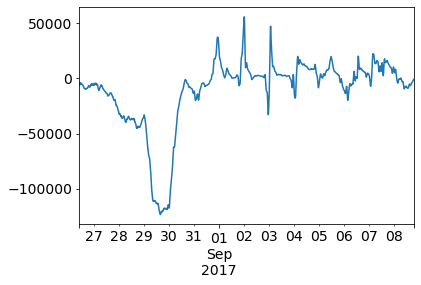

In [324]:
# (dVdtmed - Qchmed)[date_outflow:date_endoutflow].sum()*dt/1000**3
# (dVdtmed - Qch_adcp)[date_outflow:date_endoutflow].sum()*dt/1000**3
# (dVdtmed - Qchsaltmed)[date_outflow:date_endoutflow].sum()*dt/1000**3
Schroll = Sch.rolling(window=24*4*1, center=True).mean()

S = ((0.33)*df['TRIN: Salinity'] + 0.33*df['MIDG: Salinity'] + 0.33*Sch)  # volume averaged salinity
Sroll = S.rolling(window=24*4*1, center=True).mean()
V = (Amains[0] * (Hmains[0] + df['%s: Water Level [m, MHW]' % eta_main])) + (Awests[0] * (Hwests[0] + df['%s: Water Level [m, MHW]' % eta_west]))
dSVdt = (S*V).diff()/dt

Qchtemp = (1/Schroll)*dSVdt
Qchtemp.rolling(window=24*4*1, center=True).mean()[date_outflow:date_endoutflow].plot()

/Users/kthyng/miniconda3/envs/cart/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:994: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


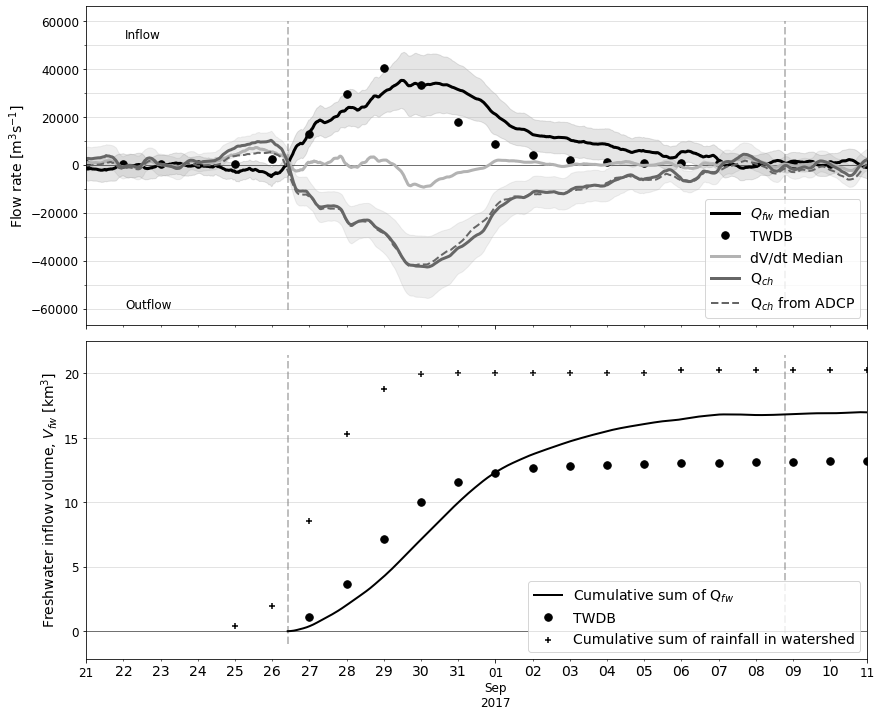

In [475]:
dstart = '2017-8-21'; dend = '2017-9-11'
tsmed = (ts.loc[:,iuse]).median(axis=1).rolling(window=24*4*1, center=True).mean()
tsstd = (ts.loc[:,iuse]).std(axis=1).rolling(window=24*4*1, center=True).mean()

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(14,12))
fig.subplots_adjust(hspace=0.05)

ax = axes[0]


## freshwater inflow

# present calculation: median and uncertainty
tsmed[dstart:dend].plot(color='k', lw=3, label='$Q_{fw}$ median', ax=ax)
ax.fill_between(df[dstart:dend].index, (tsmed - tsstd)[dstart:dend], (tsmed + tsstd)[dstart:dend], 
                color='k', alpha=0.1)#, label='$Q_{fw}$ uncertainty')

# TWDB inflow estimate
twdb.sum(axis=1)[dstart:dend].plot(color='k', lw=3, marker='.', markersize=15, linestyle='', label='TWDB', ax=ax)
# twdb['gauged'][dstart:dend].plot(color='k', lw=3, alpha=0.3, linestyle='--', label='TWDB gauged', ax=ax)

# (twdb.sum(axis=1)['2017-8-25':'2017-9-11'] + bayrain/86400).plot(color='k', lw=3, marker='x', markersize=15, ax=ax)#, linestyle='', label='TWDB', ax=ax)

# rain inflow into watershed
# newdates = pd.date_range('2017-8-25','2017-8-31', freq='1D')
# ax.scatter(newdates, rain/86400, color='k', marker='+', label='Rain into watershed')


# dVdt 
col = '0.7'
dVdtmed = dVdt.loc[:,iuse].median(axis=1).rolling(window=24*4*1, center=True).mean()
dVdtstd = dVdt.loc[:,iuse].std(axis=1).rolling(window=24*4*1, center=True).mean()
dVdtmed[dstart:dend].plot(color=col, lw=3, label='dV/dt Median', ax=ax)
ax.fill_between(df[dstart:dend].index, (dVdtmed - dVdtstd)[dstart:dend], (dVdtmed + dVdtstd)[dstart:dend], 
                color=col, alpha=0.1)#, label='dV/dt Uncertainty')


# Calculate channel flux median time series to compare with ADCP approach below
col = '0.4'
Qchmed = Qch.loc[:,iuse].median(axis=1).rolling(window=24*4*1, center=True).mean()
Qchstd = Qch.loc[:,iuse].std(axis=1).rolling(window=24*4*1, center=True).mean()
Qchmed[dstart:dend].plot(color=col, lw=3, label='Q$_{ch}$', ax=ax)
ax.fill_between(df[dstart:dend].index, (Qchmed - Qchstd)[dstart:dend], (Qchmed + Qchstd)[dstart:dend], 
                color=col, alpha=0.1)#, label='Uncertainty')

# Calculate channel flux using NOAA PORTS signal and cross-sectional area of the entrance channel calculated in
# 0_process_bathymetry notebook
Acs = bathy.attrs['Acs0'] + bathy.attrs['Dcs']*df['8771341: Water Level [m, MHW]']
Qch_adcp = df['g06010: Along [cm/s] (water)']/100*Acs
Qch_adcp.rolling(window=24*4*1, center=True).mean()[dstart:dend].plot(ax=ax, color=col, lw=2, ls='--', label='Q$_{ch}$ from ADCP')

# # Qch from salinity conservation
# Qchsaltmed = Qchsalt.loc[:,iuse].median(axis=1).rolling(window=24*4*1, center=True).mean()
# Qchsaltmed[dstart:dend].plot(color=col, lw=3, linestyle=':', ax=ax)


ax.set_ylabel('Flux terms [m$^3$s$^{-1}$]', fontsize=14)
ax.text(0.05, 0.90, 'Inflow', transform=ax.transAxes, fontsize=12)
ax.text(0.05, 0.05, 'Outflow', transform=ax.transAxes, fontsize=12)
ax.legend(loc='lower right')


# Cumulative inflow calculation
ax2 = axes[1]
(tsmed[date_outflow:dend].cumsum()*dt/1000**3).plot(color='k', lw=2, ax=ax2, label='Cumulative sum of Q$_{fw}$')

# rain time series
newdates = pd.date_range('2017-8-25','2017-9-11', freq='1D')
ax2.scatter(newdates, np.cumsum(radar.loc['all','rain [m^3]'])/1000**3, marker='+', color='k', label='Cumulative sum of rainfall in watershed')

# twdb cumulative sum
(twdb.sum(axis=1)[date_outflow:dend].cumsum()*86400/1000**3).plot(color='k', lw=3, marker='.', markersize=15, linestyle='', label='TWDB', ax=ax2)

ax2.set_ylabel('Freshwater inflow volume, $V_{fw}$ [km$^3$]', fontsize=14)
ax2.legend(loc='lower right')

ax.set_ylabel('Flow rate [m$^3$s$^{-1}$]', fontsize=14)
ax2.set_xlabel('');
ax.legend(loc='lower right')

ax.set_xlim(dstart, dend)

# add grids
ax.set_yticks(np.arange(-50000, 70000, 10000), minor=True)
# ax.yaxis.grid(True, linewidth=1.5, alpha=0.5, which='major')
ax.yaxis.grid(True, linewidth=0.7, alpha=0.5, which='both')
# ax.yaxis.grid(True, linewidth=1, alpha=0.5, axis='minor')
ax2.yaxis.grid(True, linewidth=0.7, alpha=0.5)
# # minor = mpl.dates.HourLocator(byhour=np.arange(0,24,6))
# # ax.xaxis.set_minor_locator(minor)
# major = mpl.dates.HourLocator(byhour=np.arange(0,24,24))
# ax.xaxis.set_major_locator(major)
# ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %d'))

for ax in axes:
    ylims = ax.get_ylim()
    ax.vlines(date_outflow, *ylims, linewidth=2, alpha=0.5, color='0.5', linestyle='--')
    ax.vlines(date_endoutflow, *ylims, linewidth=2, alpha=0.5, color='0.5', linestyle='--')
    ax.hlines(0, dstart, dend, lw=1, alpha=0.5)
    ax.tick_params(labelsize=12)

plt.savefig('../figures/inflow_comp.pdf', bbox_inches='tight')

/Users/kthyng/miniconda3/envs/cart/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:994: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


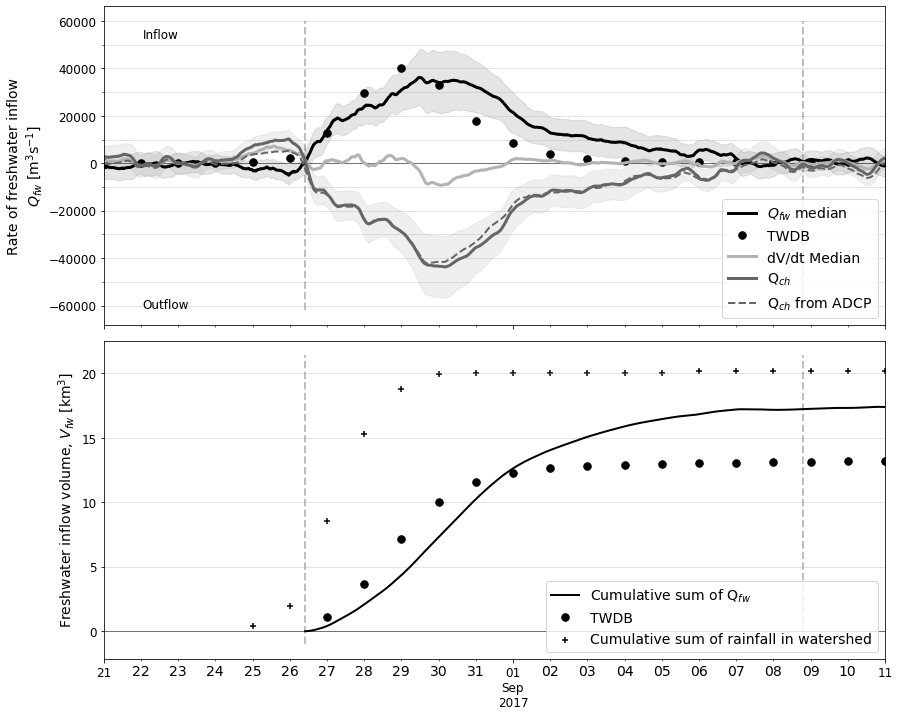

In [325]:
dstart = '2017-8-21'; dend = '2017-9-11'
tsmed = (ts.loc[:,iuse]).median(axis=1).rolling(window=24*4*1, center=True).mean()
tsstd = (ts.loc[:,iuse]).std(axis=1).rolling(window=24*4*1, center=True).mean()

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(14,12))
fig.subplots_adjust(hspace=0.05)

ax = axes[0]


## freshwater inflow

# present calculation: median and uncertainty
tsmed[dstart:dend].plot(color='k', lw=3, label='$Q_{fw}$ median', ax=ax)
ax.fill_between(df[dstart:dend].index, (tsmed - tsstd)[dstart:dend], (tsmed + tsstd)[dstart:dend], 
                color='k', alpha=0.1)#, label='$Q_{fw}$ uncertainty')

# TWDB inflow estimate
twdb.sum(axis=1)[dstart:dend].plot(color='k', lw=3, marker='.', markersize=15, linestyle='', label='TWDB', ax=ax)
# twdb['gauged'][dstart:dend].plot(color='k', lw=3, alpha=0.3, linestyle='--', label='TWDB gauged', ax=ax)

# (twdb.sum(axis=1)['2017-8-25':'2017-9-11'] + bayrain/86400).plot(color='k', lw=3, marker='x', markersize=15, ax=ax)#, linestyle='', label='TWDB', ax=ax)

# rain inflow into watershed
# newdates = pd.date_range('2017-8-25','2017-8-31', freq='1D')
# ax.scatter(newdates, rain/86400, color='k', marker='+', label='Rain into watershed')


# dVdt 
col = '0.7'
dVdtmed = dVdt.loc[:,iuse].median(axis=1).rolling(window=24*4*1, center=True).mean()
dVdtstd = dVdt.loc[:,iuse].std(axis=1).rolling(window=24*4*1, center=True).mean()
dVdtmed[dstart:dend].plot(color=col, lw=3, label='dV/dt Median', ax=ax)
ax.fill_between(df[dstart:dend].index, (dVdtmed - dVdtstd)[dstart:dend], (dVdtmed + dVdtstd)[dstart:dend], 
                color=col, alpha=0.1)#, label='dV/dt Uncertainty')


# Calculate channel flux median time series to compare with ADCP approach below
col = '0.4'
Qchmed = Qch.loc[:,iuse].median(axis=1).rolling(window=24*4*1, center=True).mean()
Qchstd = Qch.loc[:,iuse].std(axis=1).rolling(window=24*4*1, center=True).mean()
Qchmed[dstart:dend].plot(color=col, lw=3, label='Q$_{ch}$', ax=ax)
ax.fill_between(df[dstart:dend].index, (Qchmed - Qchstd)[dstart:dend], (Qchmed + Qchstd)[dstart:dend], 
                color=col, alpha=0.1)#, label='Uncertainty')

# Calculate channel flux using NOAA PORTS signal and cross-sectional area of the entrance channel calculated in
# 0_process_bathymetry notebook
Acs = bathy.attrs['Acs0'] + bathy.attrs['Dcs']*df['8771341: Water Level [m, MHW]']
Qch_adcp = df['g06010: Along [cm/s] (water)']/100*Acs
Qch_adcp.rolling(window=24*4*1, center=True).mean()[dstart:dend].plot(ax=ax, color=col, lw=2, ls='--', label='Q$_{ch}$ from ADCP')

# # Qch from salinity conservation
# Qchsaltmed = Qchsalt.loc[:,iuse].median(axis=1).rolling(window=24*4*1, center=True).mean()
# Qchsaltmed[dstart:dend].plot(color=col, lw=3, linestyle=':', ax=ax)


ax.set_ylabel('Flux terms [m$^3$s$^{-1}$]', fontsize=14)
ax.text(0.05, 0.90, 'Inflow', transform=ax.transAxes, fontsize=12)
ax.text(0.05, 0.05, 'Outflow', transform=ax.transAxes, fontsize=12)
ax.legend(loc='lower right')


# Cumulative inflow calculation
ax2 = axes[1]
(tsmed[date_outflow:dend].cumsum()*dt/1000**3).plot(color='k', lw=2, ax=ax2, label='Cumulative sum of Q$_{fw}$')

# rain time series
newdates = pd.date_range('2017-8-25','2017-9-11', freq='1D')
ax2.scatter(newdates, np.cumsum(radar.loc['all','rain [m^3]'])/1000**3, marker='+', color='k', label='Cumulative sum of rainfall in watershed')

# twdb cumulative sum
(twdb.sum(axis=1)[date_outflow:dend].cumsum()*86400/1000**3).plot(color='k', lw=3, marker='.', markersize=15, linestyle='', label='TWDB', ax=ax2)

ax2.set_ylabel('Freshwater inflow volume, $V_{fw}$ [km$^3$]', fontsize=14)
ax2.legend(loc='lower right')

ax.set_ylabel('Flow rate [m$^3$s$^{-1}$]', fontsize=14)
ax2.set_xlabel('');
ax.legend(loc='lower right')

ax.set_xlim(dstart, dend)

# add grids
ax.set_yticks(np.arange(-50000, 70000, 10000), minor=True)
# ax.yaxis.grid(True, linewidth=1.5, alpha=0.5, which='major')
ax.yaxis.grid(True, linewidth=0.7, alpha=0.5, which='both')
# ax.yaxis.grid(True, linewidth=1, alpha=0.5, axis='minor')
ax2.yaxis.grid(True, linewidth=0.7, alpha=0.5)
# # minor = mpl.dates.HourLocator(byhour=np.arange(0,24,6))
# # ax.xaxis.set_minor_locator(minor)
# major = mpl.dates.HourLocator(byhour=np.arange(0,24,24))
# ax.xaxis.set_major_locator(major)
# ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %d'))

for ax in axes:
    ylims = ax.get_ylim()
    ax.vlines(date_outflow, *ylims, linewidth=2, alpha=0.5, color='0.5', linestyle='--')
    ax.vlines(date_endoutflow, *ylims, linewidth=2, alpha=0.5, color='0.5', linestyle='--')
    ax.hlines(0, dstart, dend, lw=1, alpha=0.5)
    ax.tick_params(labelsize=12)

plt.savefig('../figures/inflow_comp.pdf', bbox_inches='tight')

For the approximate cross-sectional area at the entrance channel, what speed would the water exiting the channel have to be traveling, uniformly across the channel? 

Of course we know that the ADCP measured a lower speed, so some of the water would have been traveling yet faster for it to average to what is in the black line.

In [ ]:

(Qchmed/Acs)[dstart:dend].plot(color='k', linewidth=2, label='Q$_{ch}$')
(df['g06010: Along [cm/s] (water)']/100)[dstart:dend].plot(figsize=(15,4))


Compare effective flood/ebb areas with the calculated cross-sectional area

In [ ]:
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(14,4))
key = 'effective area (ebb)'
harv[key][iuse].hist(ax=axes[0], bins=20)
ylims = axes[0].get_ylim()
axes[0].vlines(Acs[date_outflow:date_endoutflow].mean(), 0, ylims[1])
key = 'effective area (flood)'
harv[key][iuse].hist(ax=axes[1], bins=20)
axes[1].vlines(Acs[date_outflow:date_endoutflow].mean(), 0, ylims[1])


Calculate salinity

In [210]:
V = (Amains[0] * (Hmains[0] + df['%s: Water Level [m, MHW]' % eta_main])) + (Awests[0] * (Hwests[0] + df['%s: Water Level [m, MHW]' % eta_west]))
Sch

2014-01-01 00:00:00          NaN
2014-01-01 00:15:00          NaN
2014-01-01 00:30:00          NaN
                         ...    
2018-12-31 23:30:00    16.549743
2018-12-31 23:45:00    17.333966
2019-01-01 00:00:00    18.118190
Name: BOLI: Salinity, Length: 175297, dtype: float64

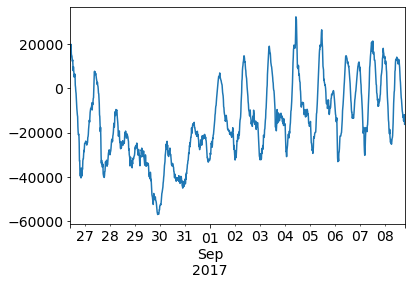

In [248]:
Qch_adcp[sdate:edate].plot()

In [259]:
date_outflow

Timestamp('2017-08-26 10:00:00')

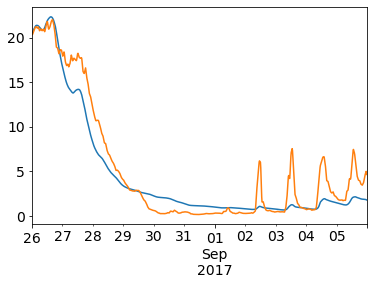

In [289]:
sdate = '2017-8-26 00:00'
edate = '2017-9-5'
# S = (dt*bathy.attrs['Acs0']/V)*(Sch*df['g06010: Along [cm/s] (water)']/100)
S = dt/V*(Sch*Qch_adcp)
Srayson = ((0.33)*df['TRIN: Salinity'] + 0.33*df['MIDG: Salinity'] + 0.33*Sch)  # volume averaged salinity
S[sdate] = Srayson[sdate]
S[sdate:edate].cumsum().plot()

Srayson[sdate:edate].plot()

## 4. Discussion

### 4.1 Comparisons

### TWDB inflow estimate

In [126]:
# integral over flooding time period
VTWDB = (twdb.sum(axis=1)[date_outflow:date_endoutflow]*86400).sum()/1000**3
print('TWDB freshwater volume inflow: %2.1f km^3' % VTWDB)

# VTWDB_gauged = (twdb['gauged'][date_outflow:date_endoutflow]*86400).sum()/1000**3
# VTWDB_ungauged = (twdb['modelled'][date_outflow:date_endoutflow]*86400).sum()/1000**3
# print('TWDB ungauged freshwater volume inflow: %2.1f km^3' % (VTWDB_ungauged))
# print('TWDB gauged freshwater volume inflow: %2.1f km^3' % (VTWDB_gauged))


per = ((Vfw - VTWDB)/VTWDB)*100
print('The present study predicts an inflow that is %2.0f percent more than the TWDB model.' % per)

per = ((Vfw - VTWDB)/Vfw)*100
print('The TWDB model inflow prediction is %2.0f percent lower than the prediction in the present study.' % per)

TWDB freshwater volume inflow: 13.1 km^3
The present study predicts an inflow that is 30 percent more than the TWDB model.
The TWDB model inflow prediction is 23 percent lower than the prediction in the present study.


In [127]:
bayrain = np.zeros(rain.time.size)
for i in range(len(radar[radar['kind'] == 'bay'])):
    bayrain += np.array(radar[radar['kind'] == 'bay']['rain [m^3]'].iloc[i])
    
bayrain /= 1000**3  # now in units of km^3/day

TWDB inflow estimate doesn't include direct rainfall onto bay. Adding in this rainfall as calculated from the radar data doesn't visibly change the signal in figure WHAT much, but it integrates over the storm period to about 1 km^3.

In [128]:
bayrain.sum()

1.0604595081652328

The TWDB estimate also doesn't account for evaporation, etc.

## Compare with ungauged subbasins

In [136]:
ungauged = radar[radar['kind'] == 'ungauged'].index
radar.loc[ungauged, 'rain total [m^3]']

8110     7.360321e+08
10062    1.440256e+08
11021    7.733968e+07
             ...     
7050     4.946253e+08
7070     3.357431e+08
7060     6.146695e+08
Name: rain total [m^3], Length: 28, dtype: float64

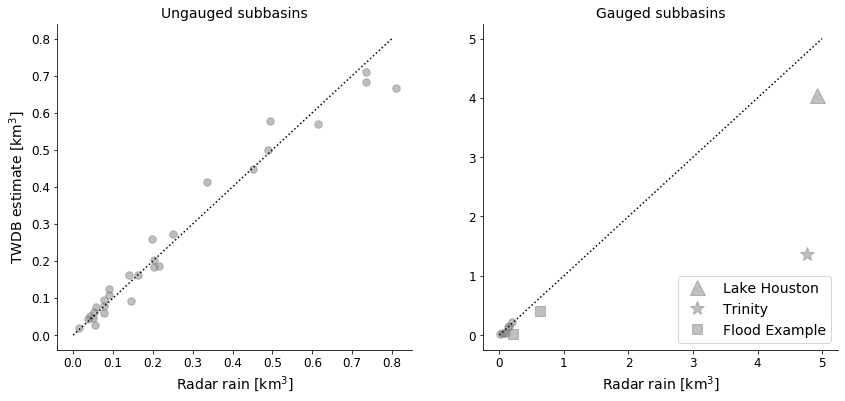

In [333]:
secondsperday = 86400
colorungauged = '0.5'
markerfillcolorun = '0.5'
colorgauged = '0.5'
markersize = 15
markerg = '.'
markerug = '.'

fig, axes = plt.subplots(1, 2, figsize=(14,6))

# ungauged
ax = axes[0]
ungauged = radar[radar['kind'] == 'ungauged'].index
rain_radar = radar.loc[ungauged, 'rain total [m^3]']/1000**3
rain_twdb = [(twdb['%s [m^3/s]' % str(basin).zfill(5)]['2017-8-25':'2017-9-9'].sum()*secondsperday)/1000**3 for basin in ungauged]
ax.plot(rain_radar, rain_twdb, marker=markerug, ls='', markersize=markersize, alpha=0.5, color=colorungauged, mfc=markerfillcolorun)
ax.set_title('Ungauged subbasins', fontsize=14)
xpts = np.linspace(0, 0.8)
ax.plot(xpts, xpts, 'k', label=None, linestyle=':')
ax.set_ylabel('TWDB estimate [km$^3$]', fontsize=14)
ax.set_xlabel('Radar rain [km$^3$]', fontsize=14)
ax.tick_params(labelsize=12)
ax.axis('tight')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


# gauged
bax = axes[1]


# for Lake Houston
lkhouston = radar[radar['kind'] == 'Lake Houston (gauged)'].index
rain_radar = (radar.loc[lkhouston, 'rain total [m^3]']/1000**3).sum()
rain_twdb = (twdb['lkhouston [m^3/s]']['2017-8-25':'2017-9-9'].sum()*secondsperday)/1000**3
plkh, = bax.plot(rain_radar, rain_twdb, marker='^', ls='', markersize=markersize, alpha=0.5, color=colorgauged)

# for Trinity
trinity = radar[radar['kind'] == 'gauged (large)'].index
rain_radar = (radar.loc[trinity, 'rain total [m^3]']/1000**3).sum()
rain_twdb = (twdb['trinity [m^3/s]']['2017-8-25':'2017-9-9'].sum()*secondsperday)/1000**3
ptrin, = bax.plot(rain_radar, rain_twdb, marker='*', ls='', markersize=markersize, alpha=0.5, color=colorgauged)

gauged = radar[radar['kind'] == 'gauged'].index
gauged = gauged.drop(['10074','10073'])  # plot separately
rain_radar = radar.loc[gauged, 'rain total [m^3]']/1000**3
rain_twdb = [(twdb['%s [m^3/s]' % str(basin).zfill(5)]['2017-8-25':'2017-9-9'].sum()*secondsperday)/1000**3 for basin in gauged]
bax.plot(rain_radar, rain_twdb, marker=markerg, ls='', markersize=markersize, alpha=0.5, color=colorgauged)
# example
rain_radar = radar.loc['10074', 'rain total [m^3]']/1000**3
rain_twdb = (twdb['%s [m^3/s]' % str(10074).zfill(5)]['2017-8-25':'2017-9-9'].sum()*secondsperday)/1000**3
p3, = bax.plot(rain_radar, rain_twdb, marker='s', ls='', markersize=10, alpha=0.5, color=colorgauged)
# example
rain_radar = radar.loc['10073', 'rain total [m^3]']/1000**3
rain_twdb = (twdb['%s [m^3/s]' % str(10073).zfill(5)]['2017-8-25':'2017-9-9'].sum()*secondsperday)/1000**3
p4 = bax.plot(rain_radar, rain_twdb, marker='s', ls='', markersize=10, alpha=0.5, color=colorgauged)

xpts = np.linspace(0, 5)
bax.plot(xpts, xpts, 'k', label=None, linestyle=':')
bax.set_xlabel('Radar rain [km$^3$]', fontsize=14)
bax.set_title('Gauged subbasins', fontsize=14)
bax.spines['right'].set_visible(False)
bax.spines['top'].set_visible(False)

bax.tick_params(labelsize=12)

bax.legend(handles=[plkh,ptrin,p3], labels=['Lake Houston', 'Trinity','Flood Example'], loc='lower right')

fig.savefig('../figures/twdb_radar_comp.pdf', bbox_inches='tight')
fig.savefig('../figures/twdb_radar_comp.png', bbox_inches='tight')



### Galveston Bay volume

In [432]:
Vall = (np.nansum(bathy['main'][:,:,0]*bathy.attrs['dx']*bathy.attrs['dy']) + np.nansum(bathy['west'][:,:,0]*bathy.attrs['dx']*bathy.attrs['dy']))/1000**3

print('The flood water could fill the bay approximately %1.0f times' % abs(Vfw/Vall))

The flood water could fill the bay approximately 5 times
